In [367]:
# !pip install tensorflow==2.15.0

In [446]:
# !pip install --upgrade tensorflow
# !pip install tensorflow==2.12.0 transformers==4.25.1
!pip install tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [447]:
# !pip install text-hammer

In [448]:
# !pip install transformers

In [449]:
# import gc
# import tensorflow as tf

# tf.keras.backend.clear_session()
# gc.collect()


In [450]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from tqdm.auto import tqdm
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

# Ensure text_hammer is installed
!pip install text_hammer
import text_hammer as th

# Ensure transformers is installed
!pip install transformers
from transformers import AutoTokenizer, TFBertModel

import tensorflow as tf

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Keras imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense

# Ensure no duplicate imports
from transformers import TFBertModel, AutoTokenizer

# Max sequence length for BERT
max_len = 36

# Rest of your model definition and training code here


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [451]:
# Load the data
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv',usecols=['id','text'])


In [374]:
# Code Block 3
# checking the size of the dataset
print("Shape of Training set:", train_data.shape)
print("Shape of Testing set:", test_data.shape)

Shape of Training set: (7613, 3)
Shape of Testing set: (3263, 2)


In [375]:
# checkout the training dataset
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [376]:
# Code Block 5
# checkout the test dataset
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


# Pre-processing the tweets:

In [377]:
# Code Block 6
# text preprocessing to remove special characters, emails, html tags and convert all tweets to lower case
def text_preprocessing(df,col_name):
    df[col_name] = df[col_name].progress_apply(lambda x:str(x).lower())
    df[col_name] = df[col_name].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))
    return(df)

In [378]:
# Code Block 7
# pre processing text column from the trainging data using the above method
train_cleaned_data = text_preprocessing(train_data,'text')

# Added: pre-processing test data to maintain consistancy 
test_cleaned_data = text_preprocessing(test_data, 'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [379]:
# Code Block 8
# checkout the data after pre-processing step
train_cleaned_data.head(10)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,i am on top of the hill and i can see a fire i...,1
8,14,there is an emergency evacuation happening now...,1
9,15,i am afraid that the tornado is coming to our ...,1


Here,
* Target 1 indicates any accident or disaster

* Target 0 indicates a formal tweets with not much attention

In [380]:
# Code Block 9
# making a copy of cleaned tarining  and testing dataset
train_data = train_cleaned_data.copy()

# Added: Making a copy of cleaned test dataset
test_data = test_cleaned_data.copy()

# Data Visualization:
## Visualization using Word Cloud:

In [381]:
# Code Block 10
# This process is only for visualization. train and test data for model will have stopwords in it
# download the stop words from NLTK and remove stop words from tweets
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

train_data_vis = train_data.copy()
train_data_vis['text'] = train_data_vis['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(train_data_vis.head())

# Edit: Added this code to remove stopwords from the test data to maintain consistency.
test_data_vis = test_data.copy()
print("-----------------------------------------------------------------------")
test_data_vis['text'] = test_data_vis['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(test_data_vis.head())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   id                                               text  target
0   1       deeds reason earthquake may allah forgive us       1
1   4              forest fire near la ronge sask canada       1
2   5  residents asked shelter place notified officer...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  got sent photo ruby alaska smoke wildfires pou...       1
-----------------------------------------------------------------------
   id                                               text
0   0                        happened terrible car crash
1   2  heard earthquake different cities stay safe ev...
2   3  forest fire spot pond geese fleeing across str...
3   9              apocalypse lighting spokane wildfires
4  11             typhoon soudelor kills 28 china taiwan


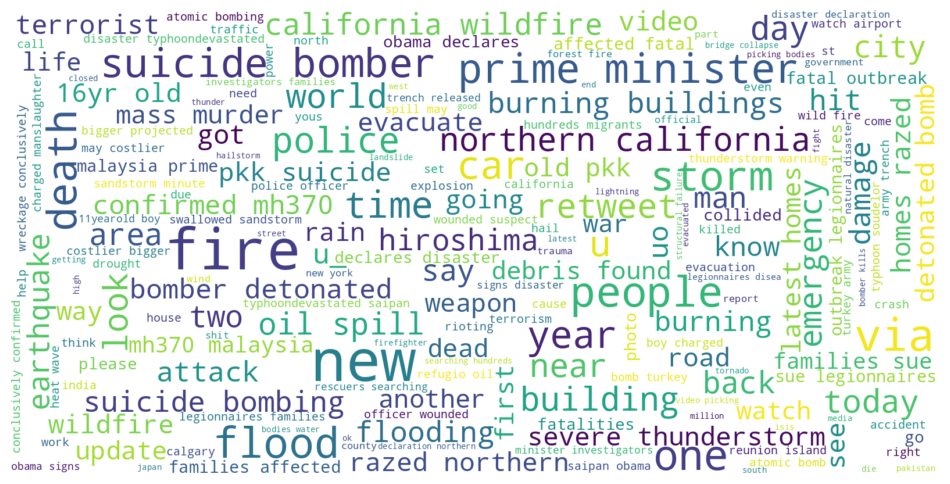

In [382]:
# Code Block 11
# Visualizing the dataset using Word Cloud after removing stopwords
# Filter all the disaster tweeets
disaster_tweets = train_data_vis[train_data_vis.target == 1]
disaster_string = list(map(lambda x: x, disaster_tweets.text))
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')

# generate the word cloud from strings in disaster tweets 
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)

# plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

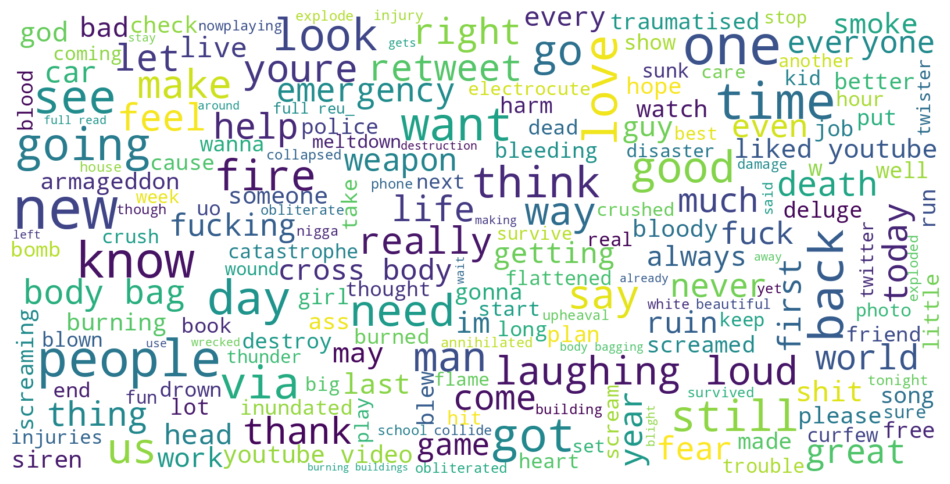

In [383]:
# Code Block 12
# Word cloud for tweets which are not disaster related 

# extract the tweets which are not realted to disaster
formal_tweets = train_data_vis[train_data_vis.target == 0]
formal_string = list(map(lambda x: x, formal_tweets.text))
formal_string = pd.Series(formal_string).str.cat(sep=' ')

# create a world cloud using the strins
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)

# plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Visualizing the Class Distribution

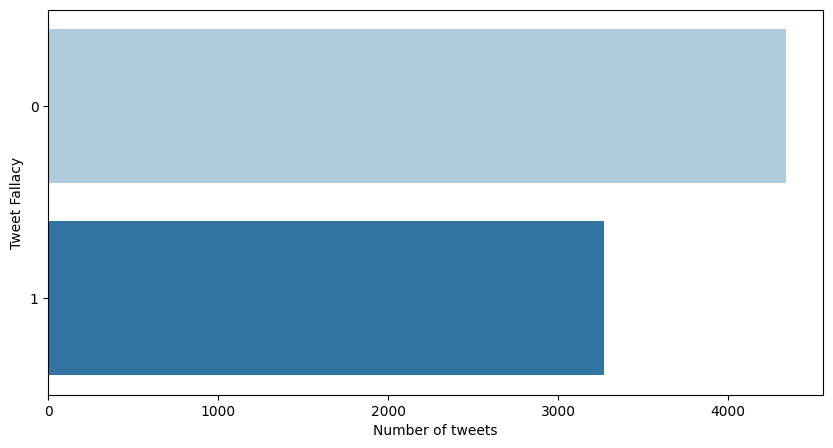

In [384]:
# Code Block 13
#Visualizing class distribution 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data_vis,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

### Visualizing the meta-features

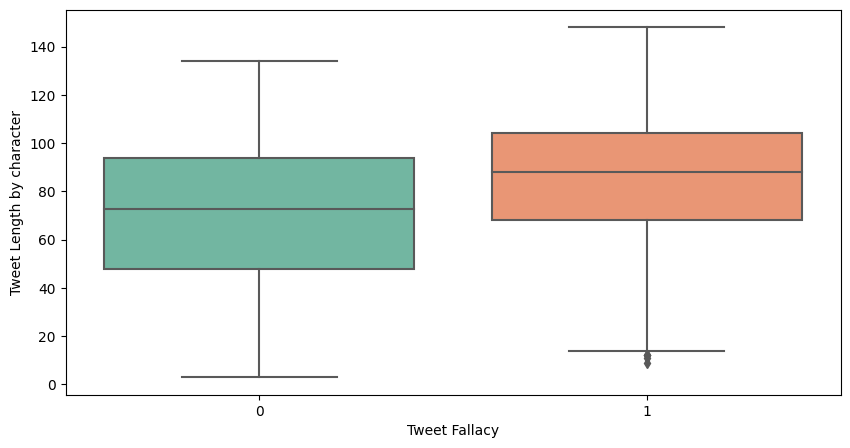

In [385]:
# Code Block 14
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data_vis['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data_vis,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

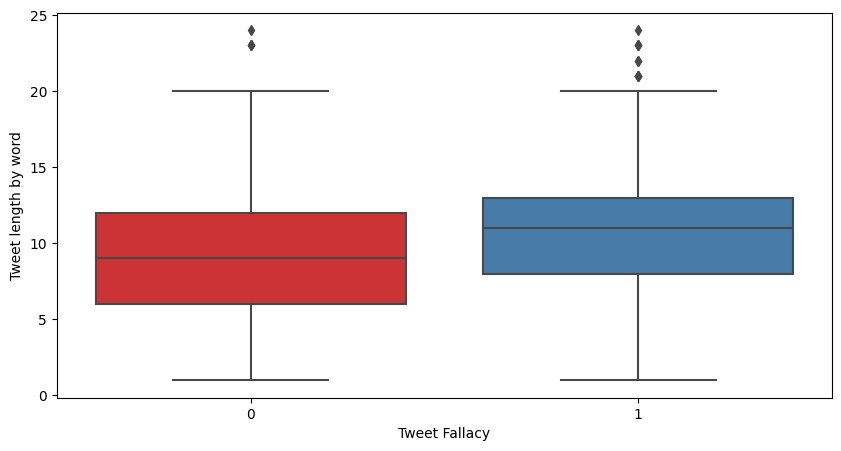

In [386]:
# Code Block 15
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data_vis['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data_vis,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [387]:
# Code Block 16
# word_count
train_data_vis['word_count'] = train_data_vis['text'].apply(lambda x: len(str(x).split()))
test_data_vis['word_count'] = test_data_vis['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data_vis['unique_word_count'] = train_data_vis['text'].apply(lambda x: len(set(str(x).split())))
test_data_vis['unique_word_count'] = test_data_vis['text'].apply(lambda x: len(set(str(x).split())))

# Commented: Stop words and URLs alread removed, no point in calculating their frequencies

# # stop_word_count
# train_data_vis['stop_word_count'] = train_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
# test_data_vis['stop_word_count'] = test_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# # url_count
# train_data_vis['url_count'] = train_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# test_data_vis['url_count'] = test_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data_vis['mean_word_length'] = train_data_vis['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data_vis['mean_word_length'] = test_data_vis['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data_vis['char_count'] = train_data_vis['text'].apply(lambda x: len(str(x)))
test_data_vis['char_count'] = test_data_vis['text'].apply(lambda x: len(str(x)))

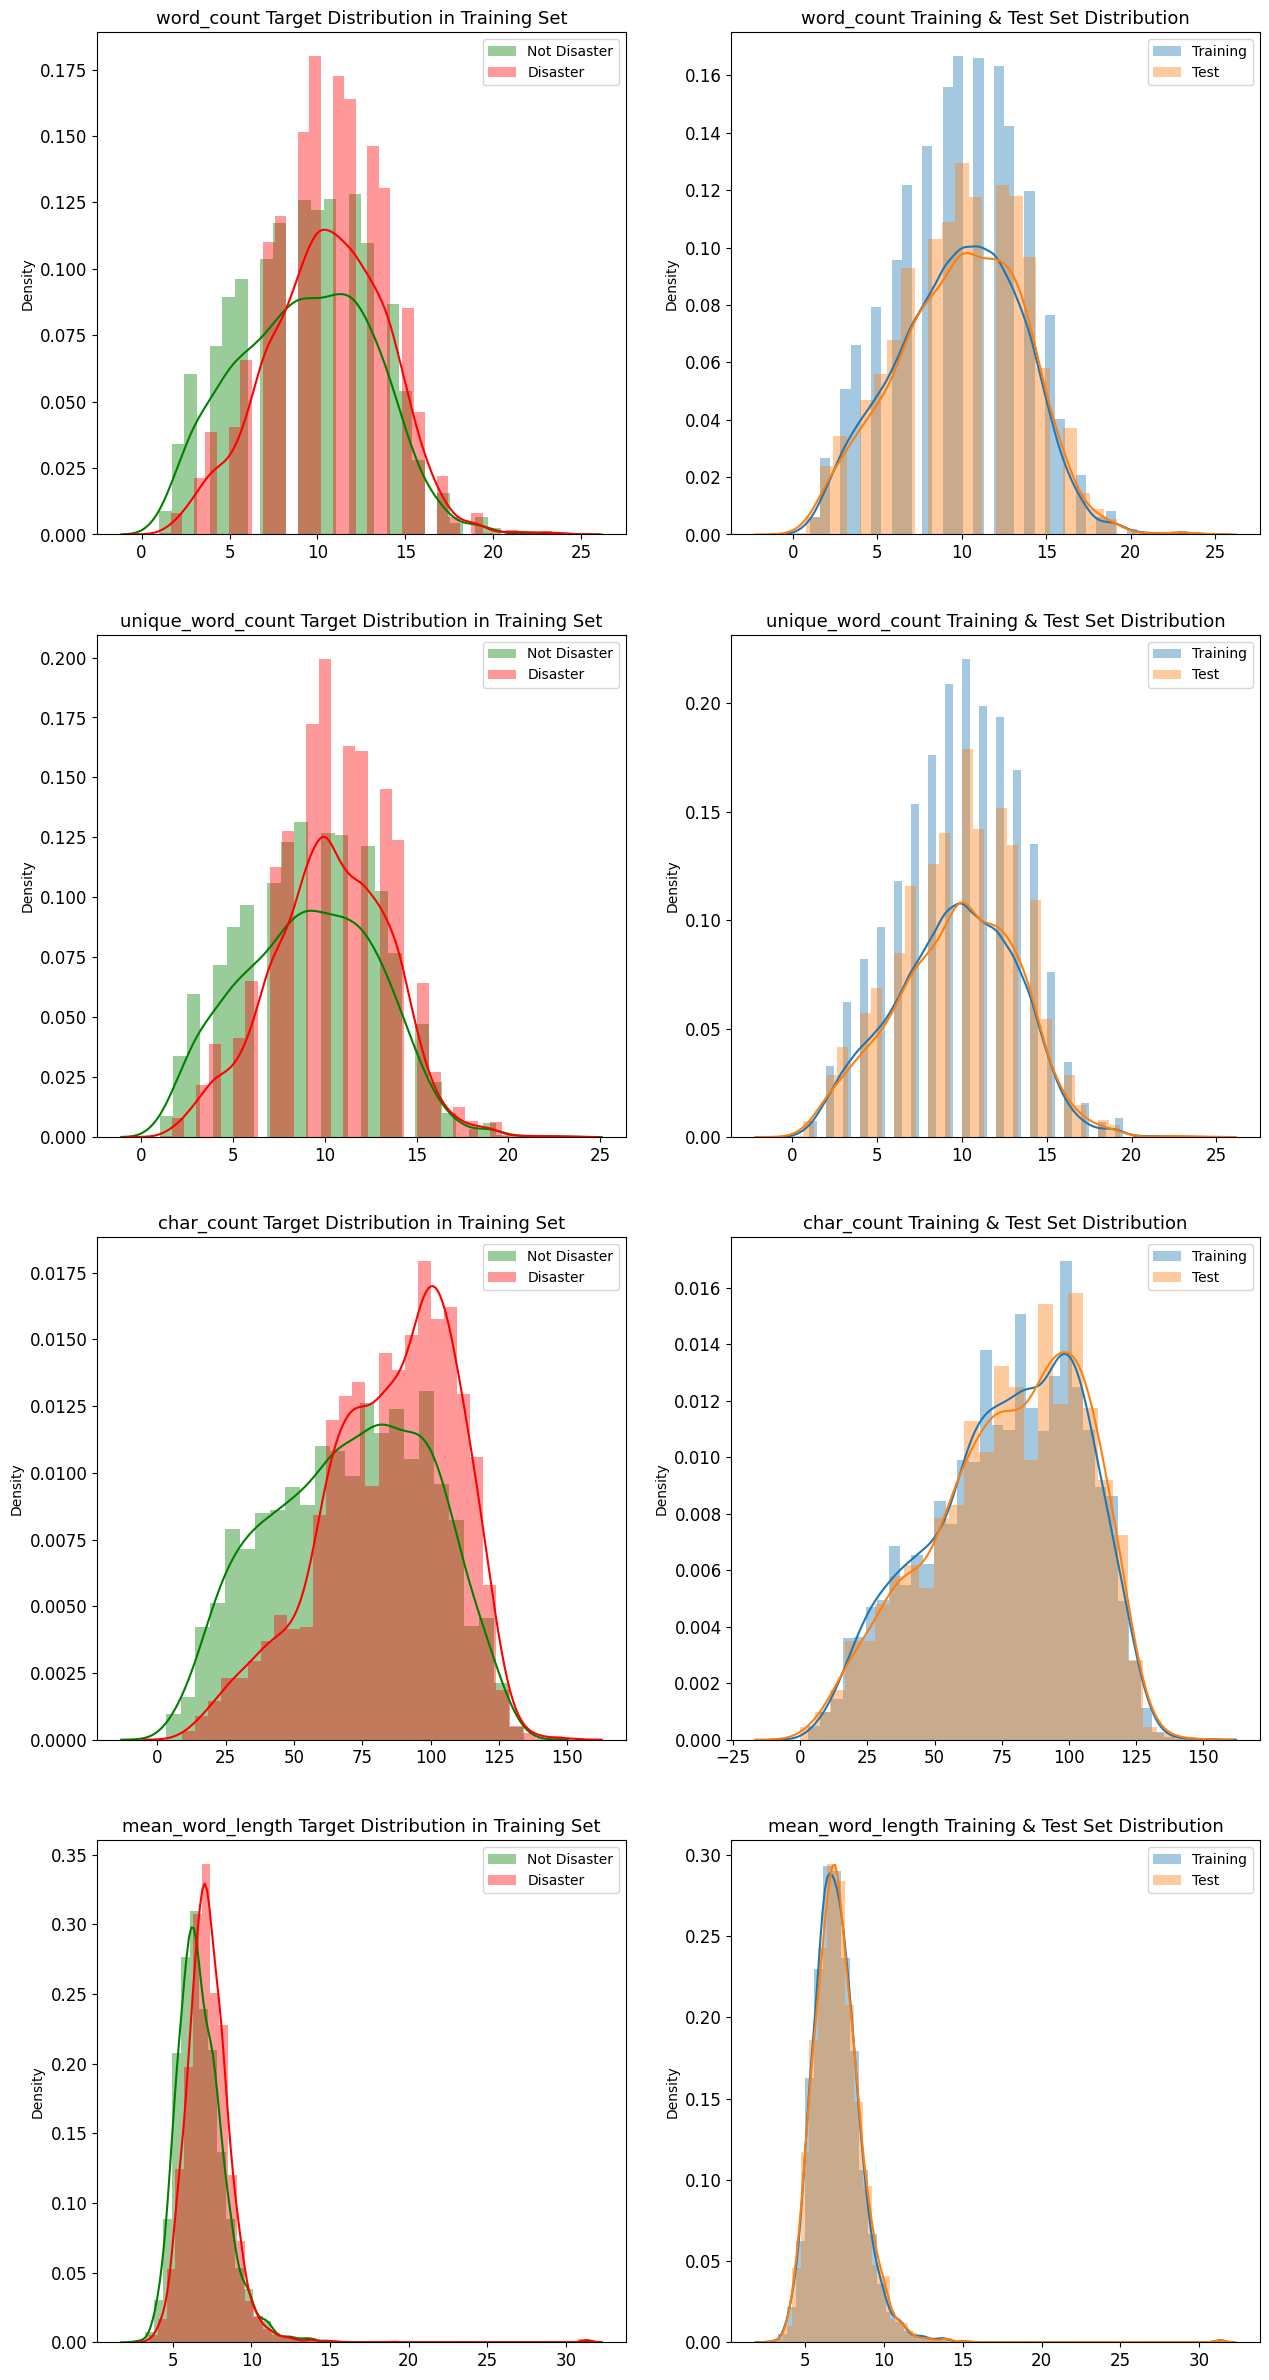

In [388]:
# Code Block 17
METAFEATURES = ['word_count', 'unique_word_count', 'char_count', 'mean_word_length']
DISASTER_TWEETS = train_data_vis['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(15, 30), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data_vis.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data_vis.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data_vis[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data_vis[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()


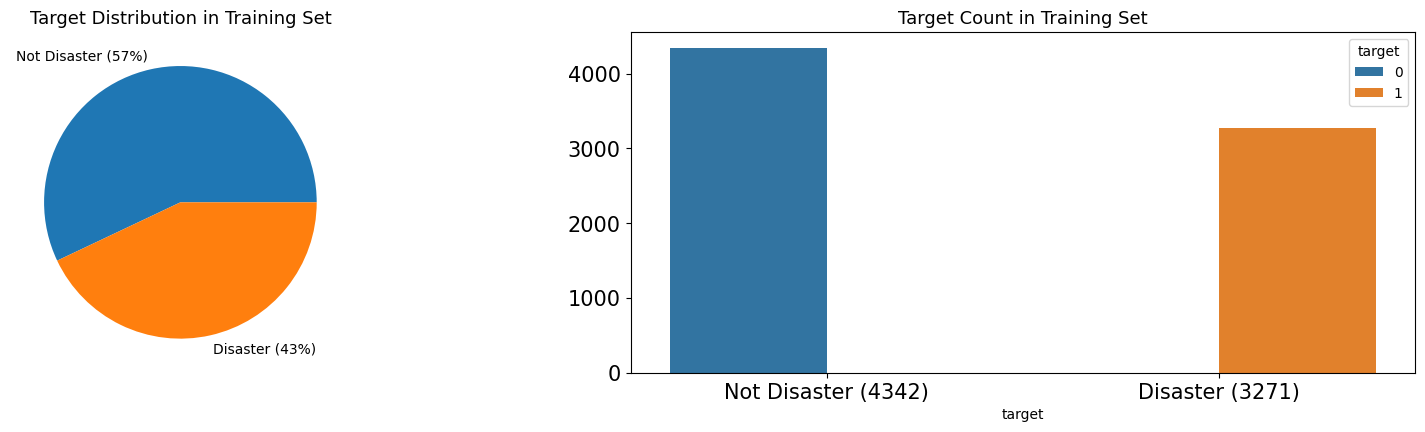

In [389]:
# Edit: Class distribution visualization is alread done. This is an extra-block, commented

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

## BERT - Bidirectional Encoder Representations from Transformers
* BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.

* The best part about BERT is that we can use the BERT models to extract high quality language features from our text data.

## Loading the BERT Model

In [390]:
# Code Block 18
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [391]:
# Code Block 19
# Testing the Tokenizer
test_token = tokenizer('Good morning have a great day &*&*&&')
print(type(test_token))
print(test_token)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
{'input_ids': [101, 2204, 2851, 2031, 1037, 2307, 2154, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## Conversion of Tweets into BERT input format:

In [392]:
# Code Block 20
print("Maximum length of tweets:",max([len(x.split()) for x in train_data.text]))
max_length = 36

Maximum length of tweets: 35


In [393]:
# Code Block 21
# x_train = tokenizer(
#                     text=train_data.text.tolist(),
#                     add_special_tokens=True,
#                     max_length=36,
#                     truncation=True,
#                     padding=True, 
#                     return_tensors='tf',
#                     return_token_type_ids = False,
#                     return_attention_mask = True,
#                     verbose = True
#                    )

# x_train
# Tokenize the training data
max_length = 36
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)


In [394]:
# Code Block 22
print("Shape of input token ids:", x_train['input_ids'].shape)
print("Shape of atteniton mask:", x_train['attention_mask'].shape)


Shape of input token ids: (7613, 36)
Shape of atteniton mask: (7613, 36)


In [395]:
# Code Block 23
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

## Building the Model Architecture:

In [441]:
import tensorflow as tf
tf.debugging.disable_check_numerics()


In [445]:
import tensorflow as tf
from tensorflow.keras.layers import Layer,Dropout, Dense
from sklearn.model_selection import train_test_split
# Set the maximum sequence length
max_len = 36
# Convert tensors to numpy arrays
x_input_ids = x_train['input_ids'].numpy()
x_attention_masks = x_train['attention_mask'].numpy()

y_train = train_data.target.values

# Split the data
x_train_val_ids, x_test_ids, x_train_val_masks, x_test_masks, y_train_val, y_test = train_test_split(
    x_input_ids, x_attention_masks, y_train, test_size=0.1, random_state=42)

x_train_ids, x_val_ids, x_train_masks, x_val_masks, y_train, y_val = train_test_split(
    x_train_val_ids, x_train_val_masks, y_train_val, test_size=0.1, random_state=42)

# Define the BERT layer
class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # pooler_output

# Input layers
input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# BERT embeddings
bert_output = BertLayer()([input_ids, input_mask])

# Add dropout and dense layers
out = Dropout(0.1)(bert_output)
out = Dense(128, activation='relu')(out)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

# Output layer
y = Dense(1, activation='sigmoid')(out)

# Create the model
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

# Setting the BERT layer as trainable
model.layers[2].trainable = True


# # Define a custom Keras layer for BERT
# class BertLayer(Layer):
#     def __init__(self, **kwargs):
#         super(BertLayer, self).__init__(**kwargs)
#         self.bert = TFBertModel.from_pretrained('bert-base-uncased')

#     def call(self, inputs):
#         input_ids, attention_mask = inputs
#         outputs = self.bert(input_ids, attention_mask=attention_mask)
#         return outputs.last_hidden_state[:, 0, :]  # pooler_output

# # Define input layers
# input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
# input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# # Get BERT embeddings
# bert_output = BertLayer()([input_ids, input_mask])

# # Add dropout and dense layers
# out = Dropout(0.1)(bert_output)
# out = Dense(128, activation='relu')(out)
# out = Dropout(0.1)(out)
# out = Dense(32, activation='relu')(out)

# # Define the output layer
# y = Dense(1, activation='sigmoid')(out)

# # Create the model
# model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

# # Setting the BERT layer as trainable
# model.layers[2].trainable = True  # Adjusting the trainability of the BERT layers if needed



ValueError: Found input variables with inconsistent numbers of samples: [7613, 7613, 6471]

In [443]:
# Code Block 25
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert_layer_9 (BertLayer)    (None, 768)                  1094822   ['input_ids[0][0]',           
                                                          40         'attention_mask[0][0]']      
                                                                                            

In [399]:
# # Define a learning rate schedule
# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
#     initial_learning_rate=6e-6,
#     decay_steps=10000,
#     end_learning_rate=0
# )

# # Create the optimizer
# optimizer = Adam(
#     learning_rate=lr_schedule,
#     epsilon=1e-8,
#     clipnorm=1.0
# )

# # Compile the model
# loss = BinaryCrossentropy(from_logits=False)
# metrics = [BinaryAccuracy()]

# model.compile(
#     optimizer=optimizer,
#     loss=loss,
#     metrics=metrics
# )
# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=6e-6,
    decay_steps=10000,
    end_learning_rate=0
)

# Optimizer
optimizer = Adam(
    learning_rate=lr_schedule,
    epsilon=1e-8,
    clipnorm=1.0
)

# Compile the model
loss = BinaryCrossentropy(from_logits=False)
metrics = [BinaryAccuracy(name='accuracy')]

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)


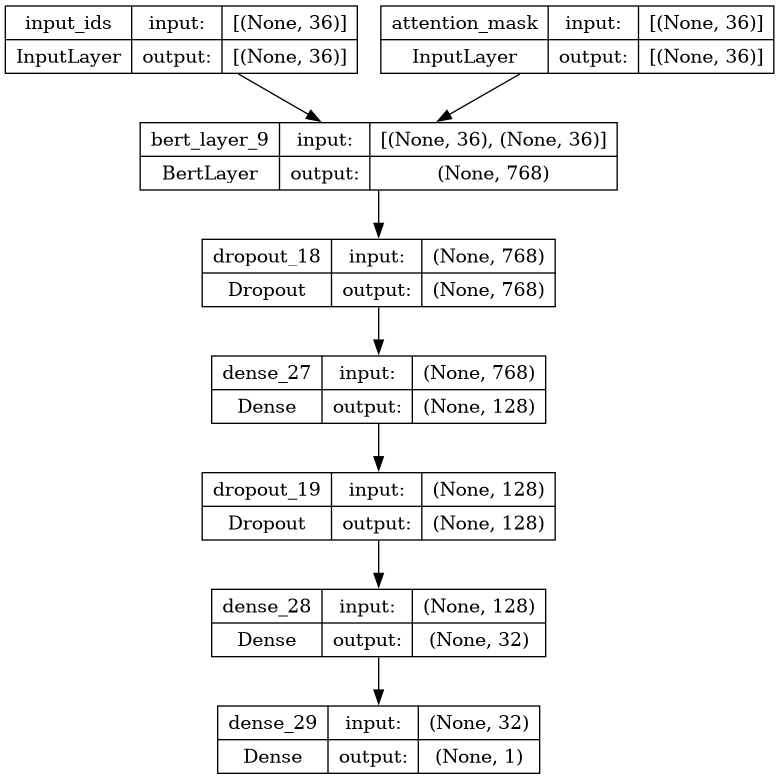

In [400]:
# Code Block 27
# Plot the model layers 
plot_model(model, show_shapes = True)

## Training the Model

In [401]:
# Code Block 28
# Train the model
# final = model.fit(
#     x={'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
#     y=y_train,
#     validation_split=0.1,
#     epochs=15,
#     batch_size=32
# )
# Train the model
final = model.fit(
    x={'input_ids': x_train_ids, 'attention_mask': x_train_masks},
    y=y_train,
    validation_data=({'input_ids': x_val_ids, 'attention_mask': x_val_masks}, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
193/193 [==============================] - 128s 352ms/step - loss: 0.4797 - accuracy: 0.7781 - val_loss: 0.4055 - val_accuracy: 0.8207
Epoch 2/10
193/193 [==============================] - 53s 273ms/step - loss: 0.3397 - accuracy: 0.8642 - val_loss: 0.4045 - val_accuracy: 0.8309
Epoch 3/10
193/193 [==============================] - 52s 267ms/step - loss: 0.2560 - accuracy: 0.9007 - val_loss: 0.4167 - val_accuracy: 0.8324
Epoch 4/10
193/193 [==============================] - 51s 266ms/step - loss: 0.0640 - accuracy: 0.9786 - val_loss: 0.6283 - val_accuracy: 0.8090
Epoch 7/10
193/193 [==============================] - 51s 266ms/step - loss: 0.0427 - accuracy: 0.9841 - val_loss: 0.7795 - val_accuracy: 0.8120
Epoch 8/10
193/193 [==============================] - 51s 265ms/step - loss: 0.0275 - accuracy: 0.9896 - val_loss: 0.7668 - val_accuracy: 0.8134
Epoch 9/10
193/193 [==============================] - 51s 265ms/step - loss: 0.0195 - accuracy: 0.9914 - val_loss: 0.8090 - val_a

In [415]:
# Extract accuracy values from training history
accuracy_values = final.history['accuracy']
val_accuracy_values = final.history.get('val_accuracy')  # Use .get() in case val_accuracy is not present

# Calculate average accuracy
average_accuracy = sum(accuracy_values) / len(accuracy_values)
average_val_accuracy = sum(val_accuracy_values) / len(val_accuracy_values) if val_accuracy_values else None

# Print average accuracies
print(f'Average training accuracy over {len(accuracy_values)} epochs: {average_accuracy:.4f}')
# if average_val_accuracy is not None:
#     print(f'Average validation accuracy over {len(val_accuracy_values)} epochs: {average_val_accuracy:.4f}')

Average training accuracy over 10 epochs: 0.9391


## Plotting the Loss and Acuracy Curve:

In [416]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']  # Use the correct key for accuracy
    loss = final.history['loss']

    epochs_plot = range(1, len(loss) + 1)
    
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('Visualization of Loss and Accuracy Curve')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

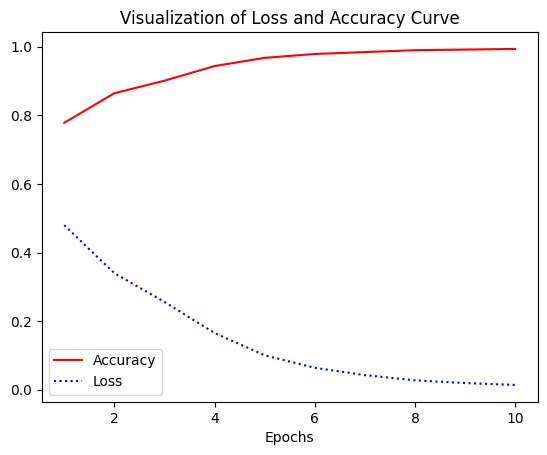

In [417]:
# Code Block 30
# Visualize accuracy and loss
visual_accuracy_and_loss(final)

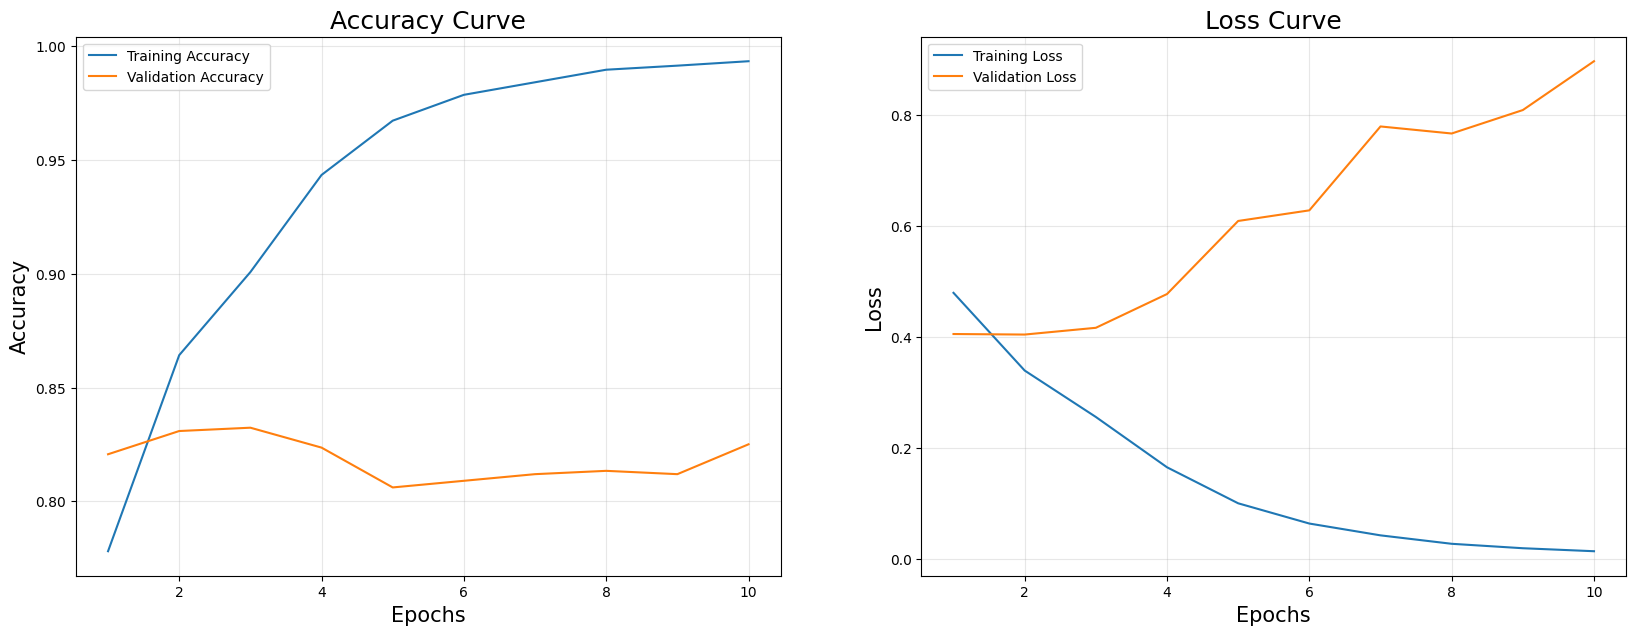

In [418]:
# Determine the number of epochs from the training history
num_epochs = len(final.history['loss'])
epochs = range(1, num_epochs + 1)

# Create a figure for the subplots
f = plt.figure(figsize=(20, 7))

# Adding Subplot 1 (For Accuracy)
f.add_subplot(121)
plt.plot(epochs, final.history['accuracy'], label="Training Accuracy")  # Training accuracy curve
plt.plot(epochs, final.history['val_accuracy'], label="Validation Accuracy")  # Validation accuracy curve

plt.title("Accuracy Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Adding Subplot 2 (For Loss)
f.add_subplot(122)
plt.plot(epochs, final.history['loss'], label="Training Loss")  # Training loss curve
plt.plot(epochs, final.history['val_loss'], label="Validation Loss")  # Validation loss curve

plt.title("Loss Curve", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

# Show the plots
plt.show()




# # Plotting subplots
# epochs = range(1, 16)  # Assuming 15 epochs were trained
# f = plt.figure(figsize=(20, 7))

# # Adding Subplot 1 (For Accuracy)
# f.add_subplot(121)

# plt.plot(epochs, final.history['accuracy'], label="accuracy")  # Accuracy curve 
# plt.plot(epochs, final.history['val_accuracy'], label="validation-accuracy")

# plt.title("Accuracy Curve", fontsize=18)
# plt.xlabel("Epochs", fontsize=15)
# plt.ylabel("Accuracy", fontsize=15)
# plt.grid(alpha=0.3)
# plt.legend()

# # Adding Subplot 2 (For Loss)
# f.add_subplot(122)

# plt.plot(epochs, final.history['loss'], label="loss")  # Loss curve 
# plt.plot(epochs, final.history['val_loss'], label="validation-loss")

# plt.title("Loss Curve", fontsize=18)
# plt.xlabel("Epochs", fontsize=15)
# plt.ylabel("Loss", fontsize=15)
# plt.grid(alpha=0.3)
# plt.legend()

# plt.show()

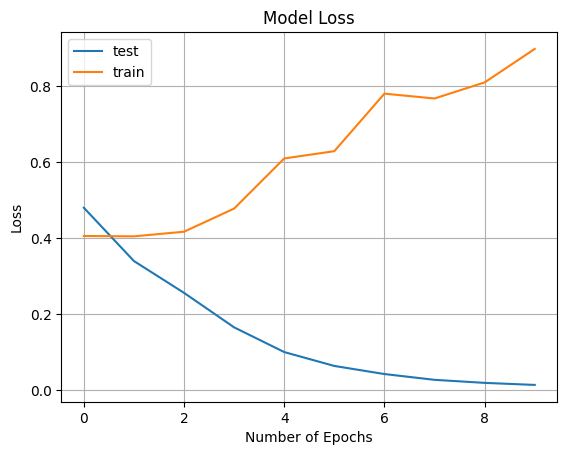

In [422]:
plt.plot(final.history['loss'], label='test')
plt.plot(final.history['val_loss'], label='train')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.grid()
plt.legend()
plt.show()

In [424]:
# Predict on the training set
# y_pred_train = model.predict({'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']})
# y_pred_train = (y_pred_train > 0.5).astype(int)

# # Import necessary libraries
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate accuracy
# train_accuracy = accuracy_score(y_train, y_pred_train)
# print("Training Accuracy:", train_accuracy)

# # Calculate precision
# precision = precision_score(y_train, y_pred_train)
# print("Precision:", precision)

# # Calculate recall
# recall = recall_score(y_train, y_pred_train)
# print("Recall:", recall)

# # Calculate F1-score
# f1 = f1_score(y_train, y_pred_train)
# print("F1-score:", f1)

# # Generate the confusion matrix
# conf_matrix = confusion_matrix(y_train, y_pred_train)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

### Testing the Model

In [425]:
# Code Block 32
# Test Input 
x_test = tokenizer(
                    text=test_data.text.tolist(),
                    add_special_tokens=True,
                    max_length=36,
                    truncation=True,
                    padding=True, 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                  )

### PREDICTION:

In [426]:
# Code Block 33
# predict
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted

102/102 [==============================] - 9s 85ms/step


array([[0.998765  ],
       [0.9993781 ],
       [0.9997894 ],
       ...,
       [0.99916255],
       [0.9964604 ],
       [0.99795   ]], dtype=float32)

In [427]:
# Code Block 34
# convert the decimal prediction values to either 0 or 1
y_predicted = np.where(predicted>0.5,1,0)
y_predicted

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [428]:
y_predicted = y_predicted.flatten()
# y_predicted = y_predicted.flatten().tolist()
# y_predicted

In [429]:
# y_test = y_test.tolist()
# y_test
y_test = np.array(y_test)

In [430]:
# Flatten y_test and y_predicted
y_test = np.array(y_test).flatten()
y_predicted = np.array(y_predicted).flatten()


In [434]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_test_pred = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed classification report
print(classification_report(y_test, y_predicted, target_names=['Non-Disaster', 'Disaster']))


102/102 [==============================] - 9s 84ms/step


ValueError: Found input variables with inconsistent numbers of samples: [762, 3263]

In [432]:
# Code Block 35
# Reshape and attach the predicted values to test dataframe

y_predicted = y_predicted.reshape((1,3263))[0]

test_data['predicted_target'] = y_predicted

print("Prediction on Test data")
print("Number of Disaster Tweets: ", test_data.predicted_target.value_counts()[1])
print("Number of Non-Disaster Tweets: ", test_data.predicted_target.value_counts()[0])

Prediction on Test data
Number of Disaster Tweets:  1232
Number of Non-Disaster Tweets:  2031


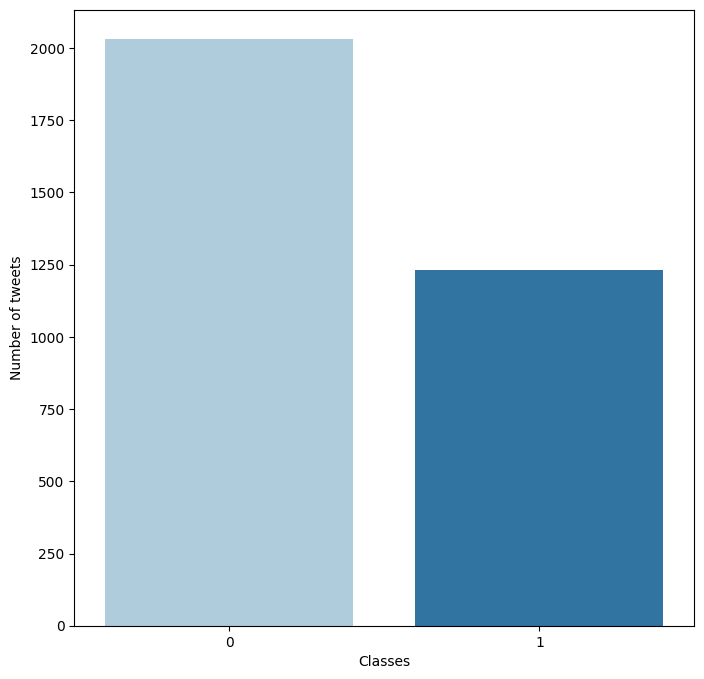

In [433]:
# Code Block 36
# sample_data.to_csv('submission.csv',index = False)
plt.figure(figsize=(8, 8))
sns.countplot(x='predicted_target',data = test_data,palette="Paired")

plt.xlabel("Classes")
plt.ylabel("Number of tweets")
plt.show()

In [ ]:
# Code Block 37
# Test a random tweet

# Replace the tweet with any tweet you like and run this block
tweet = "There is an earthquake in japan"

tokenized_tweet = tokenizer(
                    text=tweet,
                    max_length=36,
                    truncation=False,
                    padding='max_length', 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                  )
prediction = model.predict({'input_ids':tokenized_tweet['input_ids'],'attention_mask':tokenized_tweet['attention_mask']})

if (prediction > 0.5):
  print("Disaster!")
else:
  print("Not a Disaster")